In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer

from keras import Sequential
from keras.layers import Dense, Dropout, LSTM, Masking
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from support_functions import *
from batch_generators import *

Using TensorFlow backend.


In [2]:
#Import data and give column names

train = pd.read_csv('../../data/feature_selected_train_FD001.csv', sep=',', header=0, engine='python')
test = pd.read_csv('../../data/feature_selected_test_FD001.csv', sep=',', header=0, engine='python')
y_test = pd.read_csv('../../data/RUL_FD001.csv', sep=',', header=0,  engine='python')

index_names = train.columns[[0, 1]]
setting_names = train.columns[[2]]
sensor_names = train.drop(index_names.union(setting_names), axis = 1).columns # Find something better than union!!
scale_columns = sensor_names
keep_columns = scale_columns.union(index_names[[1]])

In [3]:
def create_model(x_train, y_train, x_val, y_val, epochs, model_name):
    model = Sequential()
    model.add(Masking(mask_value = -99., input_shape=(None, x_train.shape[2])))
    model.add(LSTM(256, activation='sigmoid', return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    
    optimizer = Adam(lr=1e-3)
    model.compile(loss='mean_squared_error', optimizer = optimizer)
    save_best_model = ModelCheckpoint('{}.hdf5'.format(model_name), save_best_only=True, monitor='val_loss', mode='min')
    
    #model.load_weights('simple_lstm_weights.h5')
    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=epochs,
                        batch_size=128,
                        callbacks = [save_best_model]
                       )
    return model, history

In [4]:
def load_models(x_train, y_train, x_val, y_val, epochs, model_name):
    model = load_model('{}.hdf5'.format(model_name))
    save_best_model = ModelCheckpoint('{}.hdf5'.format(model_name), save_best_only=True, monitor='val_loss', mode='min')
    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=epochs,
                        batch_size=128,
                        callbacks = [save_best_model]
                       )
    return model, history

In [5]:
def model_run(train, test, load, sequence_length, epochs, model_name, scale_columns, keep_columns):
    x_train = add_remaining_useful_life(train)
    x_train_scaled, x_test_scaled = scale_data(x_train, test, scale_columns)
    gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=1) 
    x_train, y_train, x_val, y_val = train_val_group_split(x_train_scaled.drop(['RUL'], axis = 1),
                                                           x_train_scaled[['RUL', 'unit_no']],
                                                           gss, x_train_scaled['unit_no'])
    
    generator_x_train = generator_training_wrapper(x_train, sequence_length, keep_columns)
    generator_x_val = generator_training_wrapper(x_val, sequence_length, keep_columns)

    generator_y_train = generator_label_wrapper(y_train, sequence_length, ['RUL'])
    generator_y_val = generator_label_wrapper(y_val, sequence_length, ['RUL'])

    generator_x_test = generator_test_wrapper(x_test_scaled, sequence_length, keep_columns)
    
    if(load == True):
        model, history = load_models(generator_x_train, generator_y_train, generator_x_val, generator_y_val, epochs, model_name)
    else:
        model, history = create_model(generator_x_train, generator_y_train, generator_x_val, generator_y_val, epochs, model_name)
    
    plot_loss(history)
    
    y_predicted = model.predict(generator_x_train)
    evaluate(generator_y_train, y_predicted, 'train')
    plot_predictions(generator_y_train, y_predicted)
    
    y_predicted = model.predict(generator_x_val)
    evaluate(generator_y_val, y_predicted, 'val')
    plot_predictions(generator_y_val, y_predicted)
    
    y_predicted = model.predict(generator_x_test)
    evaluate(y_test, y_predicted, 'test')
    plot_predictions(y_test, y_predicted)

train_split_engines [  1   2   3   4   5   6   7   8   9  10  12  13  14  15  16  17  19  20
  21  22  23  24  25  26  27  28  29  30  31  35  36  38  39  41  42  43
  44  46  47  48  49  50  51  54  55  56  58  59  60  61  62  63  64  65
  67  68  69  71  72  73  74  75  76  77  78  80  84  86  87  88  89  90
  91  92  95  96  97  98  99 100]
validate_split_engines [11 18 32 33 34 37 40 45 52 53 57 66 70 79 81 82 83 85 93 94] 

Train on 8743 samples, validate on 1988 samples
Epoch 1/100
8743/8743 [==============================] - 21s 2ms/step - loss: 5519.4553 - val_loss: 3548.1049
Epoch 2/100
8743/8743 [==============================] - 14s 2ms/step - loss: 4873.0299 - val_loss: 3119.0448
Epoch 3/100
8743/8743 [==============================] - 14s 2ms/step - loss: 4403.2240 - val_loss: 2771.7767
Epoch 4/100
8743/8743 [=============================

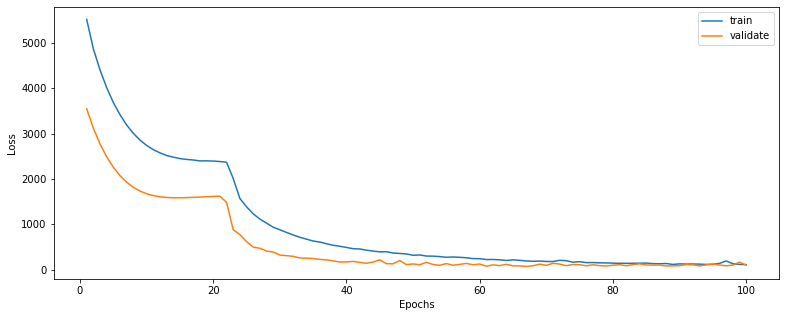

train set RMSE:8.339591979980469, R2:0.9706487254606965


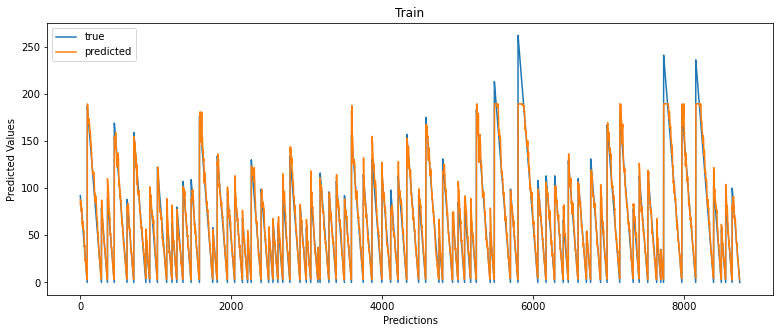

val set RMSE:9.971062660217285, R2:0.9371804767575138


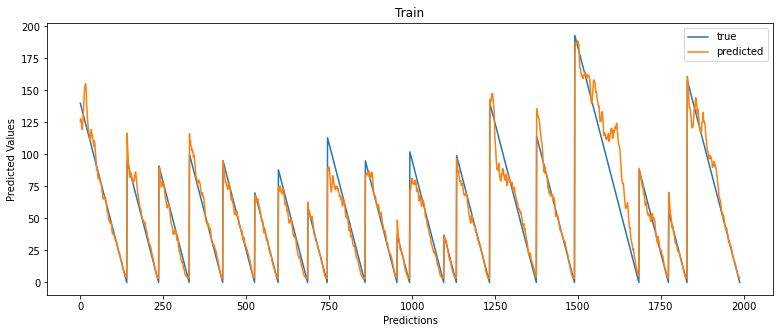

test set RMSE:22.155227904666425, R2:0.7157549571156328


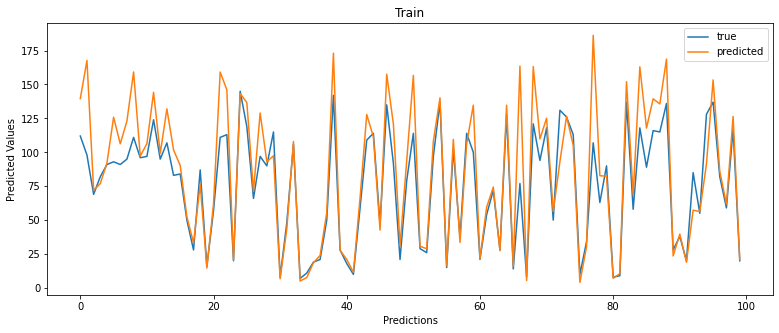

In [6]:
epochs = 100
sequence_length = 100
#model_run(train, test, load = True, sequence_length = sequence_length, epochs = epochs, model_name = 'lstm_Azure',
#         scale_columns = scale_columns, keep_columns = keep_columns)
model_run(train, test, load = False, sequence_length = sequence_length, epochs = epochs, model_name = 'lstm_test',
         scale_columns = scale_columns, keep_columns = keep_columns)